
# PFSS Extrapolation and Coronal Loop Information



#### Andy To (MSSL/UCL) - 09 September 2023


This tutorial will demonstrate how to overplot field lines onto AIA/EIS maps using the Potential Field Source Surface model (PFSS)

This tutorial will slowly take you through modelling using PFSS. This example shows how to use the Python package Sunpy (the usual package to analyse the sun!), take a PFSS solution, trace some field lines, and overplot the traced field lines on an AIA 193/EIS map.
The different parts involve:

* Installation and Requirements
* Fixing EIS pointing using AIA, and plotting solar images
* PFSS extrapolation and visualising it using EIS and AIA
* Finally we can get the loop information like magnetic loop length, and field strength along loop.




#### Installation and Requirements

If this is the first few times using Python, there are several things needed to get this going. Install the following:

Software:
`anaconda python3 pip3`

Python packages: - use `pip3 install astropy numpy sunpy pfsspy eispac matplotlib lxml`

In [18]:
# Python is very modular, so you import packages before using them.

import os

import astropy
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import sunpy.io.fits
import sunpy.map
from sunpy.net import Fido, attrs as a
from sunpy.image import coalignment
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, quantity_support
import eispac
import pfsspy
import pfsspy.tracing as tracing


Loading a Hinode/EIS map. To download EIS data for Python (.h5 files), you can look at EISpac - https://github.com/USNavalResearchLaboratory/eispac


In [19]:
eis = sunpy.map.Map('data//eis_2014_02_02__14_35_41_fe_xii_195.119_intensity.fits')

Load the corresponding AIA 193 map

In [20]:
aia = sunpy.map.Map('data/aia_lev1_193a_2014_02_02t14_35_44_22z_image_lev1.fits')

### Fixing the EIS Pointing with AIA

It is possible that the EIS pointing in these level 3 FITS files may be off, sometimes by an amount of order 10" in longitude.
We can account for this by adjusting the EIS pointing using a cross-correlation with the AIA.
We'll using the functionality provided by [scikit-image](https://scikit-image.org/) as implemented in the `sunpy.image.coalignment` subpackage to do this.

First, resample the AIA map to the same resolution as the EIS map

In [21]:
n_x = (aia.scale.axis1 * aia.dimensions.x) / eis.scale.axis1
n_y = (aia.scale.axis2 * aia.dimensions.y) / eis.scale.axis2
aia_r = aia.resample(u.Quantity([n_x, n_y]))

Next, compute the shifts, in pixels, needed to align the resampled AIA and EIS maps by cross-correlating the two images.

In [22]:
yshift, xshift = coalignment.calculate_shift(aia_r.data, eis.data)

Then find the corresponding coordinate at this pixel position in the resampled AIA map.
This can be interpreted as the location of the bottom left pixel of the EIS raster in the pixel coordinates of the AIA image. 

In [23]:
reference_coord = aia_r.pixel_to_world(xshift, yshift)

To find the amount we need to shift the original EIS map by, we can take the difference between these two coordinates and then use the `shift` method on `Map` to apply this correction to the reference coordinate (i.e. the `CRVAL` keys).

In [24]:
Txshift = reference_coord.Tx - eis.bottom_left_coord.Tx
Tyshift = reference_coord.Ty - eis.bottom_left_coord.Ty
print(f'x shift = {Txshift}')
print(f'y shift = {Tyshift}')
eis_fixed = eis.shift(Txshift, Tyshift)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
x shift = 11.763660420896485 arcsec
y shift = -1.7853901020284866 arcsec


We can see the difference by overplotting the AIA 193 intensity

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


(-0.5, 59.5, -0.5, 159.5)

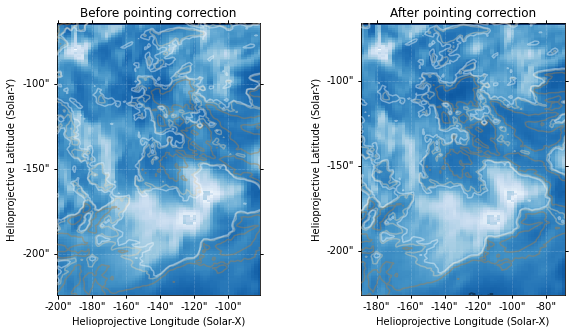

In [25]:
levels = [200, 500, 700, 800] * aia.unit
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection=eis)
eis.plot(axes=ax, title='Before pointing correction')
bounds = ax.axis()
aia_r.draw_contours(levels, axes=ax, cmap='sdoaia193', alpha=0.4)
ax.axis(bounds)
ax = fig.add_subplot(122, projection=eis_fixed)
eis_fixed.plot(axes=ax, title='After pointing correction')
bounds = ax.axis()
aia_r.draw_contours(levels, axes=ax, cmap='sdoaia193', alpha=0.4)
ax.axis(bounds)

### PFSS Extrapolation

After pointing correction, we can start doing our extrapolation using magnetic field strength data.

Some more detailed documentation can be found here: https://pfsspy.readthedocs.io/en/stable/

You can search for magnetic field data to perform field line extrapolation using the following 2 lines of code, but I have downloaded it in `data/`. For the modelling, we use the GONG instrument.

Downloading the file searched.

Loading the GONG map into sunpy

In [26]:
pfss_map = sunpy.map.Map('data/mrzqs140202t1414c2146_060.fits.gz')

We can check the pfss (magnetic field) map by calling the variable

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Observatory,NSO-GONG
Instrument,
Detector,
Measurement,676.8
Wavelength,676.8
Observation Date,2014-02-02 14:14:00
Exposure Time,Unknown
Dimension,[360. 180.] pix
Coordinate System,heliographic_carrington
Scale,[1. 0.63661914] deg / pix
Reference Pixel,[179.5 89.5] pix

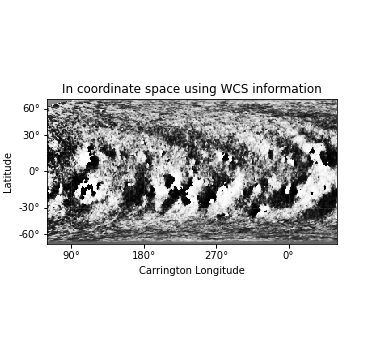
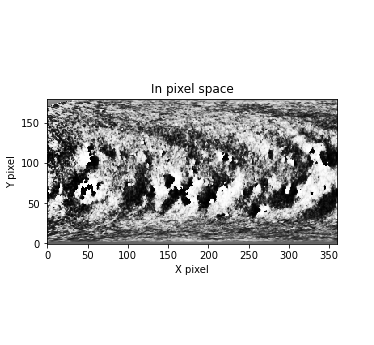
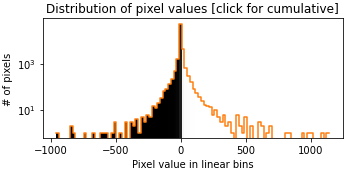
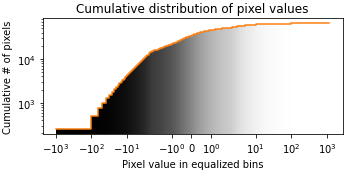

In [27]:
pfss_map

The PFSS solution is calculated on a regular 3D grid in (phi, s, rho), where
rho = ln(r), and r is the standard spherical radial coordinate. We need to
define the number of grid points in rho, and the source surface radius.

In [28]:
nrho = 39
rss = 2.5

From the boundary condition, number of radial grid points, and source
surface, we now construct an `Input` object that stores this information



In [29]:
pfss_in = pfsspy.Input(pfss_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

Using the `Input` object, plot the input photospheric magnetic field



Text(0.5, 1.0, 'Input field')

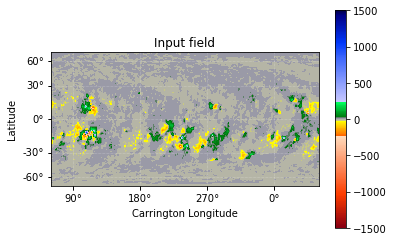

In [30]:
m = pfss_in.map
m.plot_settings = {'norm': ImageNormalize(vmin=-1.5e3,vmax=1.5e3), 'cmap': 'hmimag'}
fig = plt.figure()
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()
ax.set_title('Input field')

We can also plot the AIA map to give an idea of the global picture. There
is a nice active region in the top right of the AIA plot, that can also
be seen in the top left of the photospheric field plot above.



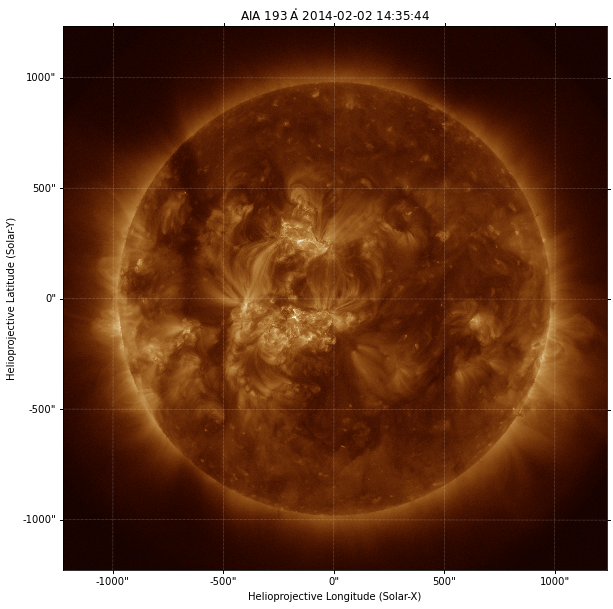

In [31]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1, projection=aia)
aia.plot(ax)

Now we construct a grid of footpoints to trace some magnetic field
lines from. These coordinates are defined in the helioprojective frame of the
AIA image

I am using a 20 x 20 "seed" for the extrapolation. You can use more/less! Just change it in the hp_lon & hp_lat

For my project, I have a seed for every pixel of the EIS map

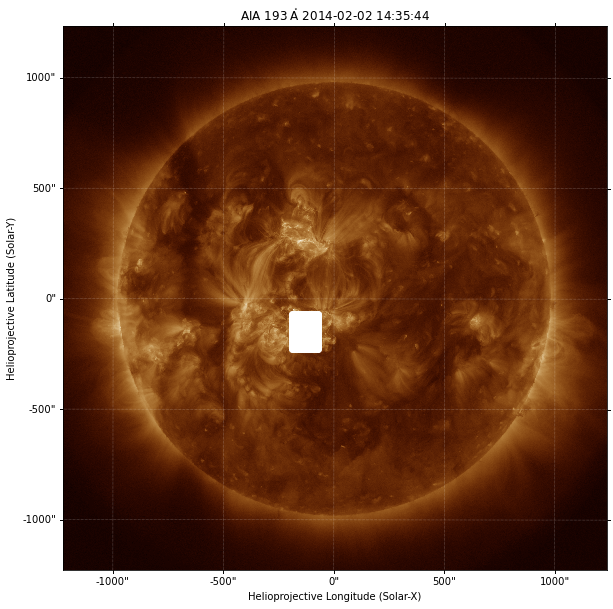

In [32]:
hp_lon = np.linspace(eis_fixed.bottom_left_coord.Tx/u.arcsec, eis_fixed.top_right_coord.Tx/u.arcsec, 20) * u.arcsec
hp_lat = np.linspace(eis_fixed.bottom_left_coord.Ty/u.arcsec, eis_fixed.top_right_coord.Ty/u.arcsec, 20) * u.arcsec

# Make a 2D grid from these 1D points
lon, lat = np.meshgrid(hp_lon, hp_lat)
seeds = SkyCoord(lon.ravel(), lat.ravel(),
                 frame=aia.coordinate_frame)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=aia)
aia.plot(axes=ax)
ax.plot_coord(seeds, color='white', marker='o', linewidth=0)

Plot the magnetogram and the seed footpoints The footpoints are centered
around the active region metnioned above.



(0.0, 179.5)

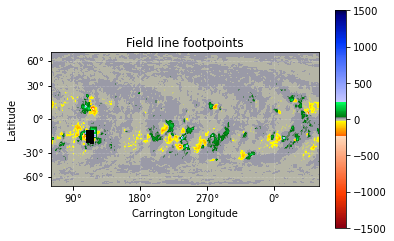

In [33]:
m = pfss_in.map
fig = plt.figure()
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()

ax.plot_coord(seeds, color='black', marker='o', linewidth=0, markersize=2)

# Set the axes limits. These limits have to be in pixel values
# ax.set_xlim(0, 180)
# ax.set_ylim(45, 135)
ax.set_title('Field line footpoints')
ax.set_ylim(bottom=0)

Compute the PFSS solution from the GONG magnetic field input



In [34]:
pfss_out = pfsspy.pfss(pfss_in)

Trace field lines from the footpoints defined above.



Plot the input GONG magnetic field map, along with the traced mangetic field
lines.

Max step is set to 80,000. 82,000 broke my computer

In [35]:
tracer = tracing.FortranTracer(max_steps=80000,step_size=0.8)
# tracer = tracing.PythonTracer()
flines = tracer.trace(seeds, pfss_out)

Plotting the extrapolated field lines from the PFSS model

Text(0.5, 1.0, 'Photospheric field and traced field lines')

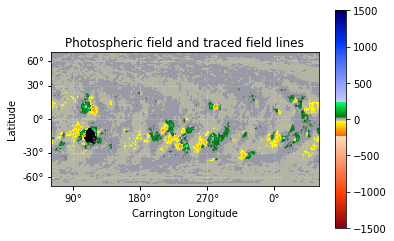

In [36]:
m = pfss_in.map
fig = plt.figure()
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()

for fline in flines:
    ax.plot_coord(fline.coords, color='black', linewidth=1)

# Set the axes limits. These limits have to be in pixel values
# ax.set_xlim(0, 180)
# ax.set_ylim(45, 135)
ax.set_title('Photospheric field and traced field lines')

Plot the AIA map, along with the traced magnetic field lines. Inside the
loop the field lines are converted to the AIA observer coordinate frame,
and then plotted on top of the map.



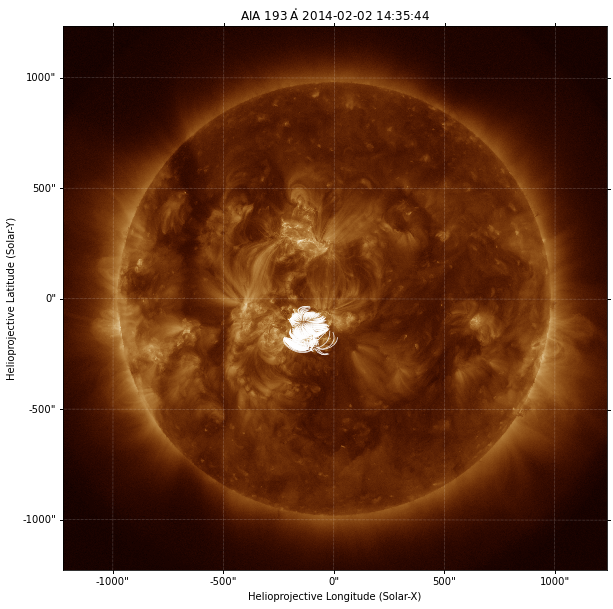

In [37]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1, projection=aia_r)
aia.plot(ax)
bounds = ax.axis()

for fline in flines:
    ax.plot_coord(fline.coords, alpha=1, linewidth=0.7, color='white')

# ax.set_xlim(500, 900)
# ax.set_ylim(400, 800)
ax.axis(bounds)
plt.show()

# sphinx_gallery_thumbnail_number = 5

Function to calculate loop length, as PFSS originates from the photosphere

In [38]:
def get_loop_length(line):
    c = line.coords.cartesian.xyz
    s = np.append(0., np.linalg.norm(np.diff(c.value, axis=1), axis=0).cumsum()) * c.unit
    return np.diff(s).sum()

Filter loop that's shorter than 5 Mm - This depends on what you want to do! I choose to filter them because I want to recreate coronal images. But maybe you don't have to:D
>Studies of the topology of the quiet Sun have shown that a significant fraction of the
field lines close at heights below 2.5 Mm, a typical chromospheric height (Close et al. 2003). Harry et al. 2007

Here I plot the fieldlines > 5 Mm onto the EIS map

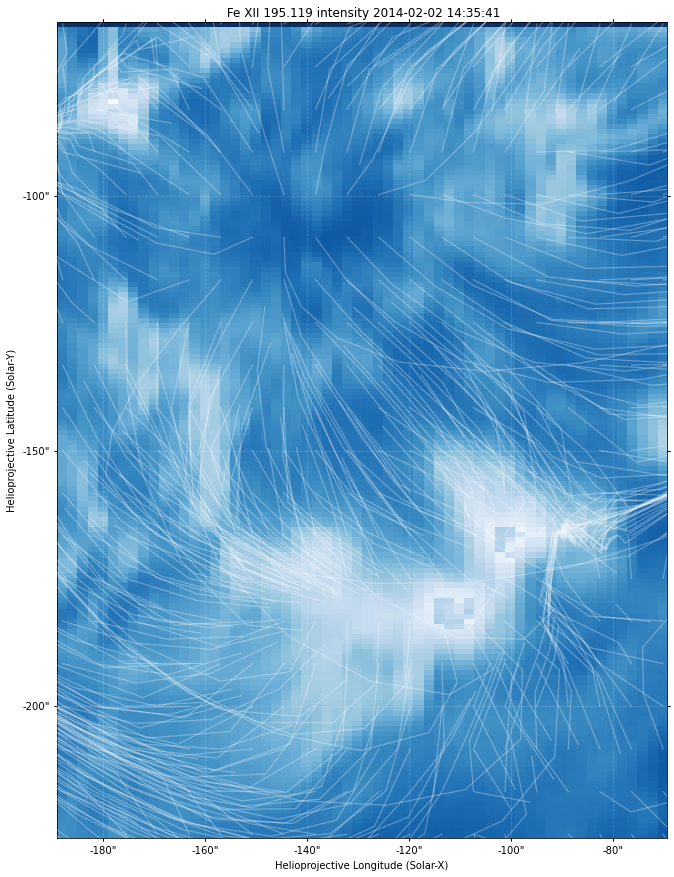

392


In [39]:
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1, 1, 1, projection=eis_fixed)
eis_fixed.plot(ax)
bounds = ax.axis()
i=0
length = []
for fline in flines:
    length.append(get_loop_length(fline).to_value(u.m))
    if get_loop_length(fline).to_value(u.m) > 5e6:
        ax.plot_coord(fline.coords, alpha=0.3, linewidth=1.2, color='white')
        i+=1
ax.axis(bounds)
plt.show()
print(i)

Calculating the median of loop length just for fun.

In [40]:
np.median(np.array(length)/1e6)


35.99229639524559

Import code to get intersecting pixels (for reconstructing coronal response later)

import coord.coord_cal as cal

In [41]:
def bresenham(x1, y1, x2, y2):
    """
    Returns an array of all pixel coordinates which the line defined by `x1, y1` and
    `x2, y2` crosses. Uses Bresenham's line algorithm to enumerate the pixels along
    a line. This was adapted from ginga

    Parameters
    ----------
    x1, y1, x2, y2 :`int`

    References
    ----------
    | https://github.com/ejeschke/ginga/blob/master/ginga/BaseImage.py#L387
    | http://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
    | https://ginga.readthedocs.org/en/latest/
    """
    for x in [x1, y1, x2, y2]:
        if type(x) not in (int, np.int64):
            raise TypeError('All pixel coordinates must be of type int')
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy
    res = []
    x, y = x1, y1
    while True:
        res.append((x, y))
        if (x == x2) and (y == y2):
            break
        e2 = 2 * err
        if e2 > -dy:
            err = err - dy
            x += sx
        if e2 <  dx:
            err = err + dx
            y += sy
    return np.array(res)


def get_intersecting_pixels(coord, image_wcs):
    # Find pixels between each loop segment
    px, py = image_wcs.world_to_pixel(coord)
    px = np.round(px).astype(int)
    py = np.round(py).astype(int)
    loop_pix = []
    for i in range(px.shape[0]-1):
        b = bresenham(px[i], py[i], px[i+1], py[i+1])
        # Pop the last one, unless this is the final entry because the first point
        # of the next section will be the same
        if i < px.shape[0]-2:
            b = b[:-1]
        loop_pix.append(b)
    return np.vstack(loop_pix)


Try this on 1 single field line

In [42]:
loop_coord = flines[100].coords


(-0.5, 59.5, -0.5, 159.5)

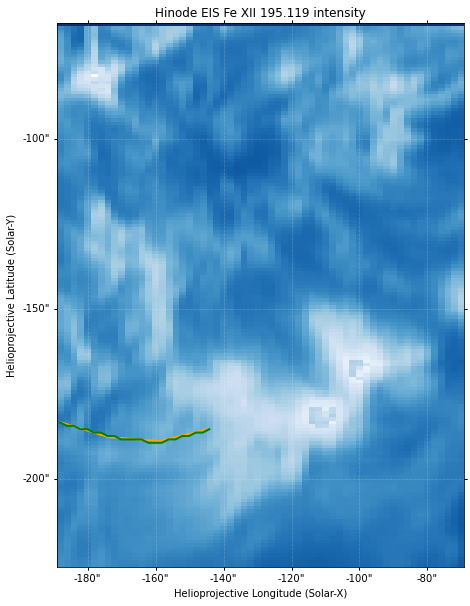

In [43]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=eis_fixed)

eis_fixed.plot(axes=ax, title=f'{eis_fixed.observatory} {eis_fixed.instrument} {eis_fixed.measurement}')
bounds = ax.axis()

ax.plot_coord(loop_coord, ls='-', lw=2, color='orange', alpha=1)
pix = get_intersecting_pixels(loop_coord, eis_fixed.wcs)
ax.plot(pix[:,0], pix[:,1], ls='-', lw=2, color='green', alpha=1)
ax.axis(bounds)


Get magnetic field along field line

Print magentic field along field line. B[:,:,0]=B_r; B[:,:,1]=B_theta; B[:,:,2]=B_phi

Getting the averaged magnetic field along field line 100.

In [45]:
i=100
sum((flines[i].b_along_fline[0])**2)**0.5

<Quantity 14.90140554 G>

Converting the magnetic field along loops to Gauss.

In [46]:
field_ = flines[i].b_along_fline.to_value(u.gauss)


In [47]:
field_

array([[-13.85056392,  -2.71309473,   4.78046893],
       [ -9.98534435,  -1.21916444,   9.30352705],
       [ -5.74314965,   1.86599595,   8.63530879],
       [ -2.67750529,   4.61881382,   3.78952821]])